# Создание нейронной сети

В этом задании мы создадим полносвязную нейронную сеть используя при этом низкоуровневые механизмы tensorflow.

Архитектутра нейросети представлена на следующем рисунке. Как видите, в ней имеется один входной слой, два скрытых, а так же выходной слой. В качестве активационной функции в скрытых слоях будет использоваться сигмоида. На выходном слое мы используем softmax.

Часть кода по созданию сети уже написана, от вас требуется заполнить пропуски в указанных местах.

## Архитектура нейронной сети

<img src="http://cs231n.github.io/assets/nn1/neural_net2.jpeg" alt="nn" style="width: 400px;"/>


## О датасете MNIST

Данную нейросеть мы будем обучать на датасете MNIST. Этот датасет представляет собой большое количество изображений рукописных цифр размером $28 \times 28$ пикселей. Каждый пиксель принимает значение от 0 до 255.

Как и раньше датасет будет разеделен на обучающую и тестовую выборки. При этом мы выполним нормализацию всех изображений, чтобы значения пикселей находились в промежутке от 0 до 1, разделив яркость каждого пикселя на 255.

Кроме того, архитектура нейронной сети ожидает на вход вектор. В нашем же случае каждый объект выборки представляет собой матрицу. Что же делать? В этом задании мы "растянем" матрицу $28 \times 28$, получив при этом вектор, состоящей из 784 элементов.

![MNIST Dataset](https://www.researchgate.net/profile/Steven-Young-5/publication/306056875/figure/fig1/AS:393921575309346@1470929630835/Example-images-from-the-MNIST-dataset.png)

Больше информации о датасете можно найти [здесь](http://yann.lecun.com/exdb/mnist/).

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [2]:
num_classes = 10 # общее количество классов, в нашем случае это цифры от 0 до 9
num_features = 784 # количество атрибутов входного вектора 28 * 28 = 784

learning_rate = 0.001 # скорость обучения нейронной сети
training_steps = 4000 # максимальное число эпох
batch_size = 256 # пересчитывать веса сети мы будем не на всей выборке, а на ее случайном подможестве из batch_size элементов
display_step = 100 # каждые 100 итераций мы будем показывать текущее значение функции потерь и точности

n_hidden_1 = 128 # количество нейронов 1-го слоя
n_hidden_2 = 256 # количество нейронов 2-го слоя

In [3]:
from tensorflow.keras.datasets import mnist

# Загружаем датасет
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Преобразуем целочисленные пиксели к типа float32
x_train, x_test = np.array(x_train, np.float32), np.array(x_test, np.float32)

# Преобразуем матрицы размером 28x28 пикселей в вектор из 784 элементов
x_train, x_test = x_train.reshape([-1, num_features]), x_test.reshape([-1, num_features])

# Нормализуем значения пикселей
x_train, x_test = x_train / 255., x_test / 255.

# Перемешаем тренировочные данные
train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))

train_data = train_data.repeat().shuffle(5000).batch(batch_size).prefetch(1)

In [4]:
print(x_test.take(2))

0.0


In [ ]:
# Создадим нейронную сеть

class DenseLayer(tf.Module):
    def __init__(self, in_features, out_features, activate_function = tf.nn.relu, name=None):
        super().__init__(name=name)
        # Место для вашего кода
        self.w = tf.Variable(tf.random.normal([in_features, out_features]), name="w")
        self.b = tf.Variable(tf.zeros([out_features]), name="b")
        self.activate_function = activate_function

    def __call__(self, x):
        # Место для вашего кода
        y = tf.matmul(x, self.w) + self.b
        return self.activate_function(y)



class NN(tf.Module):
  def __init__(self, name=None):
    super().__init__(name=name)
    # Первый слой, состоящий из 128 нейронов
    # Место для вашего кода
    self.layer_1 = DenseLayer(in_features=num_features, out_features=n_hidden_1, activate_function = tf.nn.sigmoid)

    # Второй слой, состоящий из 256 нейронов
    # Место для вашего кода
    self.layer_2 = DenseLayer(in_features=n_hidden_1, out_features=n_hidden_2, activate_function = tf.nn.sigmoid)

    # Выходной слой
    # Место для вашего кода
    self.out_layer = DenseLayer(in_features=n_hidden_2, out_features=10, activate_function = tf.nn.softmax)

  def __call__(self, x):
    # Место для вашего кода
    x = self.layer_1(x)
    x = self.layer_2(x)

    # Помните что для выхода нейронной сети мы применяем к выходу функцию softmax. 
    # Делаем мы это для того, чтобы
    # выход нейронной сети принимал значения от 0 до 1 в соответствии с вероятностью 
    # принадлежности входного объекта к одному из 10 классов

    # Место для вашего кода
    x = self.out_layer(x) 
    return x

In [ ]:
# В качестве функции ошибки в данном случае удобно взять кросс-энтропию
def cross_entropy(y_pred, y_true):
    # Encode label to a one hot vector.
    y_true = tf.one_hot(y_true, depth=num_classes)

    # Clip prediction values to avoid log(0) error.
    y_pred = tf.clip_by_value(y_pred, 1e-9, 1.)

    # Вычисление кросс-энтропии
    return tf.reduce_mean(-tf.reduce_sum(y_true * tf.math.log(y_pred)))

# В качестве метрики качества используем точность
def accuracy(y_pred, y_true):
    # Место для вашего кода
    acc = tf.metrics.Accuracy()
    acc.update_state(y_true, tf.argmax(y_pred, axis=1))
    return acc.result().numpy()

In [ ]:


# Функция обучения нейросети
def train(nn, input_x, output_y):
  # Для подгонки весов сети будем использовать стохастический градиентный спуск
  optimizer = tf.optimizers.SGD(learning_rate=learning_rate)

  # Активация автоматического дифференцирования
  with tf.GradientTape() as g:
    #pred = neural_net(input_x)
    pred = nn(input_x)
    loss = cross_entropy(pred, output_y)
        
    # Создадим оптимизируемых список параметров
    # Место для вашего кода
    trainable_variables = nn.trainable_variables

    # Вычислим по ним значение градиента
    dydx = g.gradient(loss, trainable_variables)
    
    # Модифицируем параметры
    # Место для вашего кода
    optimizer.apply_gradients(zip(dydx, trainable_variables))

In [ ]:
# Тренировка сети

# Создадим экзампляр нейронной сети
neural_net = NN(name="mnist")

loss_history = []  # каждые display_step шагов сохраняйте в этом список текущую ошибку нейросети
accuracy_history = [] # каждые display_step шагов сохраняйте в этом список текущую точность нейросети

# В этом цикле мы будем производить обучение нейронной сети
# из тренировочного датасета train_data извлеките случайное подмножество, на котором 
# произведется тренировка. Используйте метод take, доступный для тренировочного датасета.

for step, (batch_x, batch_y) in enumerate(train_data.take(training_steps)):

    # Обновляем веса нейронной сети
    # Место для вашего кода
    train(neural_net, batch_x, batch_y)

    if step % display_step == 0:
        # Место для вашего кода
        current_loss = cross_entropy(neural_net(x_test), y_test).numpy()
        loss_history.append(current_loss)

        result_neural_net = neural_net(x_test)
        current_accuracy = accuracy(result_neural_net, y_test)
        accuracy_history.append(current_accuracy)


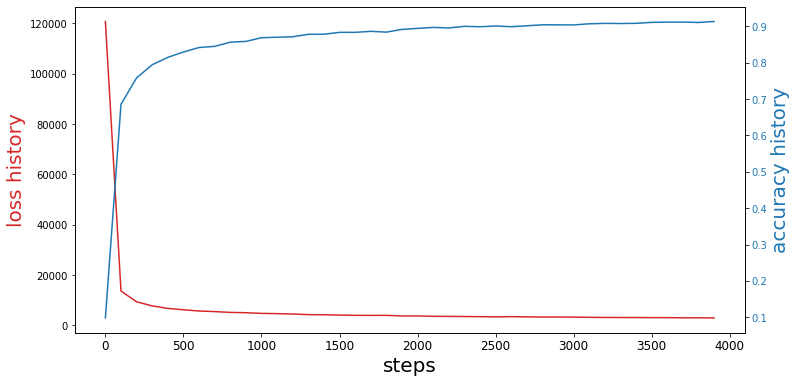

In [ ]:
# Выведите графики зависимости изменения точности и потерь от шага
# Если все сделано правильно, то точность должна расти, а потери уменьшаться

# Место для вашего кода
import matplotlib.pyplot as plt
import pandas as pd

steps = pd.RangeIndex(0,training_steps, display_step)

fig, ax1 = plt.subplots(figsize=(12,6))
ax1.plot(steps, loss_history,  color='tab:red')

ax2 = ax1.twinx() 
ax2.plot(steps, accuracy_history, color='tab:blue')

ax1.set_xlabel('steps', fontsize=20)
ax1.tick_params(axis='x', rotation=0, labelsize=12)
ax1.set_ylabel('loss history', color='tab:red', fontsize=20)

ax2.set_ylabel("accuracy history", color='tab:blue', fontsize=20)
ax2.tick_params(axis='y', labelcolor='tab:blue')


In [ ]:
accuracy_history


[0.0981,
 0.6853,
 0.7579,
 0.794,
 0.8142,
 0.829,
 0.8413,
 0.8445,
 0.856,
 0.8581,
 0.8683,
 0.8696,
 0.8708,
 0.8776,
 0.8778,
 0.883,
 0.883,
 0.8858,
 0.8836,
 0.8911,
 0.8938,
 0.8966,
 0.895,
 0.8995,
 0.8984,
 0.9004,
 0.8985,
 0.901,
 0.9037,
 0.9036,
 0.9034,
 0.9065,
 0.9077,
 0.9072,
 0.9078,
 0.9104,
 0.9111,
 0.9112,
 0.9101,
 0.9129]

In [ ]:
# Вычислите точность обученной нейросети

# Место для вашего кода
result_neural_net = neural_net(x_test)
current_accuracy = accuracy(result_neural_net, y_test)
current_accuracy

In [ ]:
# Протестируем обученную нейросеть на 10 изображениях. Из тестовой выборки возьмите 5 
# случайных изображений и передайте их в нейронню сеть.
# Выведите изображение и выпишите рядом ответ нейросети.
import random
import matplotlib.pyplot as plt

testing_indexes = random.sample(range(len(y_test)), 5)
predictions = neural_net(x_test).numpy()
for i in testing_indexes:
  plt.imshow(np.reshape(x_test[i],(28,28)))
  plt.show()
  print('predict - ', np.argmax(predictions[i]))
  print(predictions[i])



In [ ]:
# Сделайте вывод о том ошибается ли ваша нейронная сеть и если да, то как часто?

# Место для вашего кода
collect_mistakes_x = []
collect_mistakes_y = []
collect_mistakes_pred_y = []
len_test_collection = len(y_test)
for i in range(len_test_collection):
  y_predict = np.argmax(predictions[i])
  if y_predict != y_test[i]: 
    collect_mistakes_x.append(x_test[i])
    collect_mistakes_y.append(y_test[i])
    collect_mistakes_pred_y.append(predictions[i])
print(f'number of mistakes is {len(collect_mistakes_y)} from {len_test_collection}')
  

In [ ]:
counters = dict()
for number in range(10):
  print(f"mistakes of '{number}'")
  count = 0
  #print(number, collect_mistakes_y[i])
  for i in range(len(collect_mistakes_y)):
    if number == collect_mistakes_y[i]:
      count += 1
      #plt.imshow(np.reshape(collect_mistakes_x[i],(28,28)))
      #plt.show()
      #print(f'Must be {collect_mistakes_y[i]}, but predicted - {np.argmax(collect_mistakes_pred_y[i])}')
      #print(f'because probability tensor was {collect_mistakes_pred_y[i]}')  
  counters[number] = count
print(counters)

In [ ]:
a = {0: 52, 1: 28, 2: 124, 3: 94, 4: 110, 5: 153, 6: 71, 7: 88, 8: 132, 9: 140}
b = {0: 35, 1: 48, 2: 89, 3: 154, 4: 126, 5: 137, 6: 65, 7: 121, 8: 126, 9: 127}
c = {0: 41, 1: 31, 2: 107, 3: 113, 4: 91, 5: 142, 6: 60, 7: 103, 8: 140, 9: 133}

Найбільше помилок робиться на "складних" цифрах - 3, 5, 8, 9.
Загальний відсоток помилок - десь 10%. Це багато.